In [1]:
import sys
sys.path.append('..')

import argparse
import torch

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path

import requests
from PIL import Image
from io import BytesIO
import json
from transformers import TextStreamer

from utils.data import get_data, show_data

In [2]:
MODEL_NAME = "liuhaotian/llava-v1.6-34b"
temperature = 0.2
max_new_tokens = 512
num_models = 2
models = []

disable_torch_init()

model_name = get_model_name_from_path(MODEL_NAME)
for i in range(num_models):
    tokenizer, model, image_processor, context_len = load_pretrained_model(MODEL_NAME, model_base=None, model_name=model_name, load_8bit=False, load_4bit=False, device_map="auto")
    models.append({"tokenizer":tokenizer, "model":model, "image_processor":image_processor, "context_len":context_len})

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.class_embedding: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.patch_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assi

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

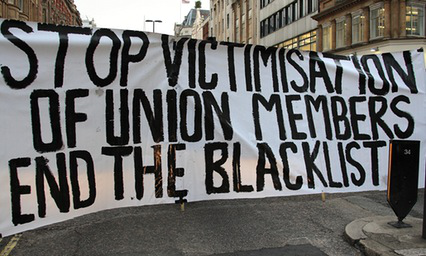

Caption:  Flashmob protest at Crossrail site in Central London by Unite union members in protest against blacklisting and sackings of union officials and members
Misinformation (Ground Truth): False


In [3]:
if "llama-2" in model_name.lower():
    conv_mode = "llava_llama_2"
elif "mistral" in model_name.lower():
    conv_mode = "mistral_instruct"
elif "v1.6-34b" in model_name.lower():
    conv_mode = "chatml_direct"
elif "v1" in model_name.lower():
    conv_mode = "llava_v1"
elif "mpt" in model_name.lower():
    conv_mode = "mpt"
else:
    conv_mode = "llava_v0"

conv = []
roles = []

for i in range(num_models):
    conv.append(conv_templates[conv_mode].copy())
    if "mpt" in model_name.lower():
        roles.append(('user', 'assistant'))
    else:
        roles.append(conv[i].roles)

image, caption, img_path, annotation = get_data(0)
display(image)
show_data(0)
image_size = image.size
# Similar operation in model_worker.py
image_tensor = process_images([image], models[0]['image_processor'], models[0]['model'].config)
if type(image_tensor) is list:
    image_tensor = [image.to(models[0]['model'].device, dtype=torch.float16) for image in image_tensor]
else:
    image_tensor = image_tensor.to(models[0]['model'].device, dtype=torch.float16)



In [4]:
annotation['falsified']

False

In [5]:
def initial_prompt(role, text):
    prompt = """{}: Given the text: {}. Does this text belong to the same context as the image or is the image being used out of context to spread misinformation?
                    The image is real. It has not been digitally altered. 
                    Carefully examine the image for any watermarks, text and other details which could tell you about the location, time or other important information to better inform your answer.
                    Explain your answer in detail. 
                    At the end give a definite YES or NO or UNSURE answer to this question: MISINFORMATION?""".format(role, text)
    return prompt

In [6]:
def round1_prompt(role, text):
    prompt = """ {}: This is what I think: {}. Do you agree with me? If you think I am wrong then convince me.
            Clearly state your reasoning and tell me if I am missing out on some important information or am making some logical error.
            Do not describe the image. 
            At the end give a definite YES or NO answer to this question: MISINFORMATION?
            """.format(role, text)
    return prompt

In [7]:
def debate_prompt(role, text):
    prompt = """ {}: I see what you mean and this is what I think: {}. Do you agree with me?
                If not then point out the inconsistencies in my argument (e.g. location, time or person related logical confusion) and explain why you are correct. 
                If you disagree with me then clearly state why and what information I am overlooking.
                You can also ask me rebutal questions to find loopholes in my reasoning. 
                Don't give up your original opinion without clear reasons, DO NOT simply agree with me without proper reasoning.
                At the end give a definite YES or NO answer to this question: MISINFORMATION?
            """.format(role, text)
    return prompt

In [8]:
#print(f"{roles[1]}: ", end="")
num_rounds = 3
temp=""
model_responses = {}
for i in range(num_models):
    model_responses[i] = {"falsified":"", "output":""}
for round in range(num_rounds+1):
    if round != 0:
        print("========== Debate Round: {} ==========".format(round))
    for i in range(num_models):
        if round == 0:
            inp = initial_prompt(roles[i][0], caption)
            print("INPUT MESSAGE: ", inp)
        elif round == 1:
            if i == 1:
                inp = round1_prompt(roles[i][0], temp)
                print("INPUT MESSAGE: ", inp)
            else:
                inp = round1_prompt(roles[i][0], conv[(i+1)%num_models].messages[-1][-1])
        else:
            inp = debate_prompt(roles[i][0], conv[(i+1)%num_models].messages[-1][-1])
            print("INPUT MESSAGE: ", inp)
        print("========================== Agent - {} =====================".format(i+1))
        if image is not None:
            # first message
            if models[i]['model'].config.mm_use_im_start_end:
                inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
            else:
                inp = DEFAULT_IMAGE_TOKEN + '\n' + inp
            if round == 0 and i == 1:
                print("image is none!")
                image = None

        conv[i].append_message(conv[i].roles[0], inp)
        conv[i].append_message(conv[i].roles[1], None)
        prompt = conv[i].get_prompt()

        input_ids = tokenizer_image_token(prompt, models[i]['tokenizer'], IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(models[i]['model'].device)
        stop_str = conv[i].sep if conv[i].sep_style != SeparatorStyle.TWO else conv[i].sep2
        keywords = [stop_str]
        streamer = TextStreamer(models[i]['tokenizer'], skip_prompt=True, skip_special_tokens=True)

        with torch.inference_mode():
            output_ids = models[i]['model'].generate(
                input_ids,
                images=image_tensor,
                image_sizes=[image_size],
                do_sample=True if temperature > 0 else False,
                temperature=temperature,
                max_new_tokens=max_new_tokens,
                streamer=streamer,
                use_cache=True)

        outputs = models[i]['tokenizer'].decode(output_ids[0]).strip()
        conv[i].messages[-1][-1] = outputs
        print("==========", outputs)
        if i == 0 and round == 0:
            temp = outputs
        if round == 3:
            #final answer from the model
            if "YES" in outputs:
                model_responses[i]["falsified"] = "True"
                model_responses[i]["output"] = outputs
            elif "NO" in outputs:
                model_responses[i]["falsified"] = "False"
                model_responses[i]["output"] = outputs

        #print("\n", {"prompt": prompt, "outputs": outputs}, "\n")

INPUT MESSAGE:  <|im_start|>user
: Given the text: Flashmob protest at Crossrail site in Central London by Unite union members in protest against blacklisting and sackings of union officials and members. Does this text belong to the same context as the image or is the image being used out of context to spread misinformation?
                    The image is real. It has not been digitally altered. 
                    Carefully examine the image for any watermarks, text and other details which could tell you about the location, time or other important information to better inform your answer.
                    Explain your answer in detail. 
                    At the end give a definite YES or NO or UNSURE answer to this question: MISINFORMATION?
========================== Agent - 1 =====================
The image shows a banner with the text "STOP VICTIMISATION OF UNION MEMBERS OF THE BLACKLIST END THE BLACKLIST". The banner is displayed in a public space, and there are buildings i